In this notebook we do a first exploration of some audio data, to extract individual noise samples, gather them into a dataset, and train a neural net to recognize them. There are only two types of noises so far: the isolated consonant sounds 't' and 'p'. Note by 'noise' here and throughout we mean percussive mouth noises, not background static noise.

# Data loading and cleaning

In [2]:
# load the audio files, and give each noise a label
# we'll assume each file contains multiple, spaced reptitions of the same noise
from pydub import AudioSegment
directory = "./recordings/sennheiser/"
noise_audio = {
    't': AudioSegment.from_file(directory + 't1.m4a'),
    'p': AudioSegment.from_file(directory + 'p1.m4a')
}

# get some basic properties
frame_rate = { n: noise_audio[n].frame_rate for n in noise_audio }
print("Frame rates:", frame_rate)
# print(noise_t_audio.duration_seconds)
# print(noise_t_audio.duration_seconds * noise_t_audio.frame_rate == noise_t_audio.frame_count())
# print(noise_t_audio.sample_width)
# print(noise_t_audio.channels)

# convert to mono, so each frame has only one sample
noise_audio_mono = { n: noise_audio[n].set_channels(1) for n in noise_audio }

# finally, convert to a more workable data type
import pandas as pd
noise_sample_array = {n: noise_audio_mono[n].get_array_of_samples() for n in noise_audio }
noise_series = { n: pd.Series(noise_sample_array[n], name=n) for n in noise_audio }

noises = pd.concat(noise_series.values(), axis=1)

Frame rates: {'t': 44100, 'p': 44100}


In [3]:
# We may need these later
import numpy as np
import matplotlib.pyplot as plt

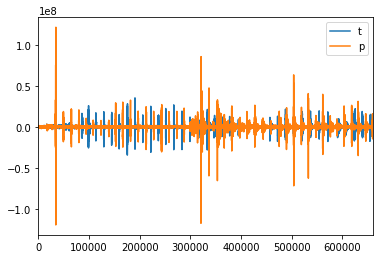

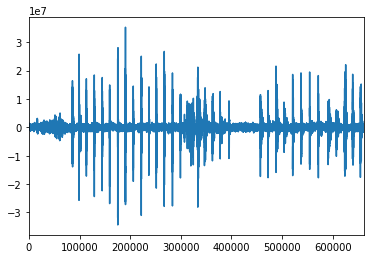

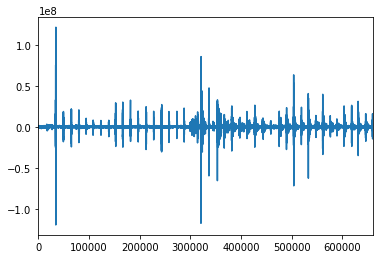

In [4]:
# visualize, to make sure things are sensible so far
length = 15 * frame_rate['t']
noises[:length].plot()
plt.figure()
noises['t'][:length].plot()
plt.figure()
noises['p'][:length].plot()

Zooming in on a couple representative spikes, we see they
* are quite distinct, 
* begin abruptly, and 
* last <~ 3000 frames ~ 0.07s

Duration shown: 0.22675736961451248
Duration shown: 0.22675736961451248


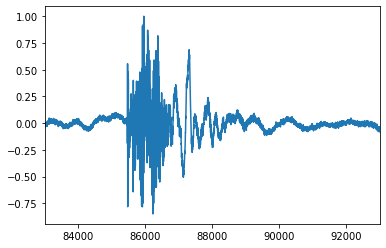

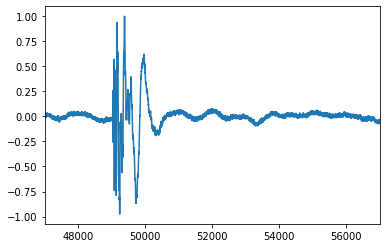

In [6]:
start    = 83000
duration = 10000
t_example = noises['t'][start:start+duration]
t_example /= t_example.apply(abs).max()
t_example.plot()
print("Duration shown:", duration / frame_rate['t'])

# play the sample. sounddevice is easier to use than pydub for this
import sounddevice as sd
data = t_example / 10
fr = frame_rate['t']
if False:
    sd.play(data, fr)
    sd.wait()

start    = 47000
duration = 10000

plt.figure()
p_example = noises['p'][start:start+duration]
p_example /= p_example.max()
p_example.plot()
print("Duration shown:", duration / frame_rate['t'])

data = p_example / 10
if False:
    sd.play(data, fr)

We want to isolate each of these spikes from the recording automatically, as individual "observations" of the desired noise. To do so we need to estimate when each noise starts, and how long it lasts. We'll assume short, percussive noises for now (not drawn out, like a hisssss).

{'t': 7054231.2, 'p': 32285209.6}


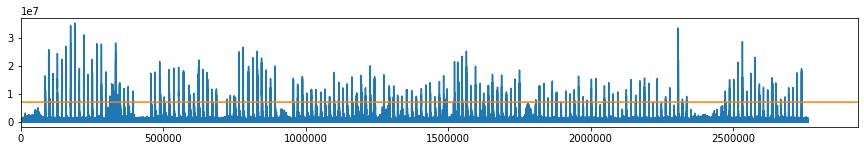

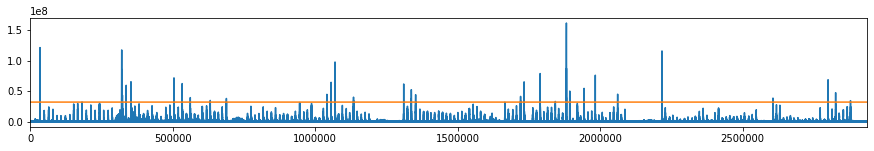

In [7]:
# To isolate the spikes, look for points with (absolute value) at least 20% of the maximum (absolute value)
SPIKE_THRESHOLD_FRACTION = .20
noises_abs = noises.apply(abs)
spike_thresholds = { n: noises_abs[n].max() * SPIKE_THRESHOLD_FRACTION for n in noises }
print(spike_thresholds)

# How does this look?


for n in noises:
    plt.figure(figsize=(15,2))
    noises_abs[n].plot()
    
    x = range(len(noises))
    yval = spike_thresholds[n]
    plt.plot(x, [yval] * len(x), label=n)

It seems to catch most of them for 't', but misses a lot of them for 'p'. Looking in terms of dB isn't much more enlightening:

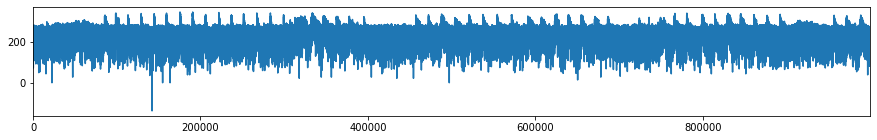

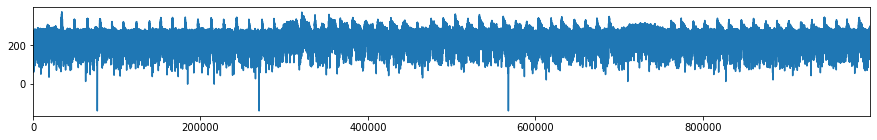

In [8]:
noises_abs_dB = noises.apply(lambda x: 20 * np.log(abs(x) + 0.001))

start = 0
end   = 10**6
for n in noises:
    plt.figure(figsize=(15,2))
    noises_abs_dB[n][start:end].plot()

To find the spikes, then, let's scan and look for peaks in amplitude. We observed earlier that each spike lasts a few 10s of ms, so let's scan in batches of ~0.02 sec, looking for with the amplitude in one batch is substantially larger than the previous. This should also help to avoid loud but non-percussive noises (like a breath or word) that might otherwise clutter the data.

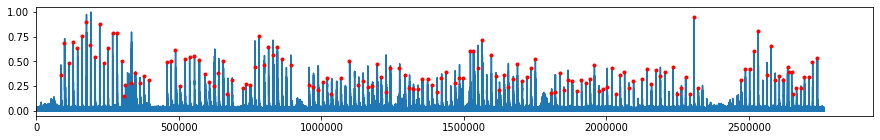

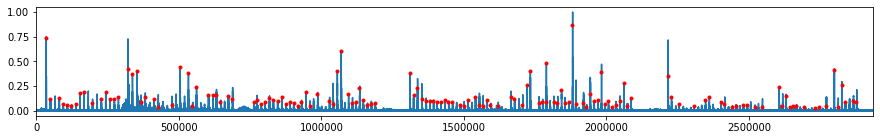

In [9]:
BATCH_DURATION = 0.02 # look at BATCH_DURATION (seconds) at a time
THRESHOLD_MULTIPLIER = 5 # detect a spike when the next batch is at least THRESHOLD_MULTIPLIER times bigger

spike_locations  = { n: [] for n in noises }
batch_amplitudes = { n: [] for n in noises }
spike_amplitudes = { n: [] for n in noises }
for n in noises:
    data  = noises[n].apply(abs)
    data /= data.max() # normalize
    batch_size = round(BATCH_DURATION * frame_rate[n])
    number_of_batches = len(data) // batch_size
    
    last_amplitude = 1 # initialize variable
    for b in range(number_of_batches):
        start = batch_size * b
        end   = batch_size * (b + 1)
        amplitude = data[start:end].max()
#         batch_amplitudes[n].append(amplitude)
        if amplitude > THRESHOLD_MULTIPLIER * last_amplitude:
            spike_locations[n].append(start)
            spike_amplitudes[n].append(amplitude)
        last_amplitude = amplitude
    
    # visualize the spike locations
    plt.figure(figsize=(15,2))
    data.plot()
    for i in range(len(spike_locations[n])):
        x = spike_locations[n][i]
        y = spike_amplitudes[n][i]
        plt.plot([x], [y], marker='o', markersize=3, color="red")


At least by visual inspection, this seems to have caught most volume spikes relatively well. Let's now grab a window around each spike, that we'll use for analysis and training. This will create one dataframe per isolated noise. We'll also normalize them while we're at it, to have the same average amplitude.

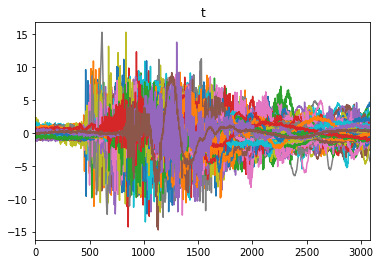

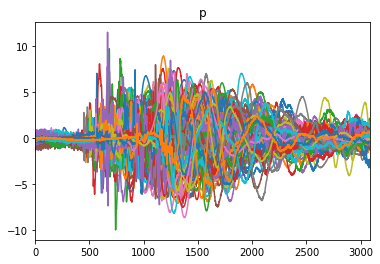

In [10]:
BEFORE = 0.5 * BATCH_DURATION # the time (sec) to look before the spike location
AFTER  = 3 * BATCH_DURATION # the time (sec) to look after the spike location

noises_isolated = {}

def normalize(series):
    mean = series.apply(abs).mean()
    return series / mean

for n in noises:
    df = pd.DataFrame()
    b = round(BEFORE * frame_rate[n])
    a = round(AFTER  * frame_rate[n])
    LABEL = '_obs'
    for s in spike_locations[n]:
        obs = noises[n].iloc[ s-b : s+a ].reset_index(drop=True)
        df[n + LABEL + str(s)] = normalize(obs)
    
    noises_isolated[n] = df
    noises_isolated[n].plot(legend=False, title=n)

These observations are all the same length, and have no missing data. This is dependent on two things: 
* the before and after intervals were identical because the frame rates were identical (different frame rates might yield off by one differences because of rounding)
* the spikes are all sufficiently displaced from the ends of the data that there is always enough data to grab a full before and after interval

The former we could control by matching all the frame rates before proceeding. The latter will be important for training anyways, so we can instruct users to leave enough quiet space at the beginning and ends of the recordings. This will not be hard, because we only need 32ms per observation.

In [11]:
# There is no missing data
[ noises_isolated[n].isnull().any().any() for n in noises ]

[False, False]

Let's listen to the samples, to see if they sound reasonable. They generally sound pretty good, though the 'p' noise seems often dominated by air blowing into the microphone rather than the lip pop itself. That will likely vary quite a bit based on the microphone and microphone position used, so we should keep an eye on this.

In [12]:
for n in noises:
    fr = frame_rate[n]
    for obs_label, obs_data in noises_isolated[n].iteritems():
        obs_data /= 10
        if False:
            sd.play(obs_data, fs)
            sd.wait()

# Classification by spectrograms

To classify these, we will compute their spectrograms and classify the resulting images. To begin, we will use Mel Spectrograms (which show more distinct features), and a Convolutional Neural Net (CNN) to classify them, since CNN's have shown particular success in image classification. We will use PyTorch for both of these tasks. (Ultimately we might wish to use PyTorch for the original audio processing, as well.)

Note: With a dataset as small as ours, it may make more sense to use a simpler method for image classification: deep learning with a CNN may overfit, or otherwise be an unnecessarily large hammer for this problem. We'll proceed anyways to try it out. If it struggles for lack of data, we could even go a transfer learning route, leveraging existing nets trained on much larger image sets.

In [13]:
import torch
import torchaudio

Let's take a look at a couple spectrograms to settle on what we want to compare. We will also need to convert to our noises to torch tensors for manipulation.

In [14]:
# Here are the full audio files
tfull = torch.tensor(noises['t'], dtype=torch.float)
pfull = torch.tensor(noises['p'], dtype=torch.float)

# and a couple isolated examples
t0 = torch.tensor(noises_isolated['t'].iloc[:,0])
p0 = torch.tensor(noises_isolated['p'].iloc[:,0])

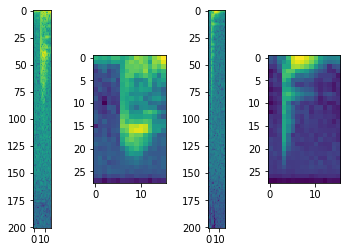

In [15]:
# some normal and mel spectrograms
n_mels = 28
specgram_t    = torchaudio.transforms.Spectrogram()(t0)
melspecgram_t = torchaudio.transforms.MelSpectrogram(
    sample_rate=frame_rate['t'], n_mels=n_mels)(t0)
specgram_p    = torchaudio.transforms.Spectrogram()(p0)
melspecgram_p = torchaudio.transforms.MelSpectrogram(
    sample_rate=frame_rate['p'], n_mels=n_mels)(p0)

fig, ax = plt.subplots(1, 4)
ax[0].imshow(specgram_t.log2().numpy())
ax[1].imshow(melspecgram_t.log2().numpy())
ax[2].imshow(specgram_p.log2().numpy())
ax[3].imshow(melspecgram_p.log2().numpy())

For some reason using n_mels too large (>= 47, for the parameters we chosen so far) results in white bars, some mel filterbanks that are identically zero at all times. I don't quite understand this, but a smaller image is probably sufficient anyways, so we'll table this for now. We'll use the mel spectrograms (the second and fourth images) for classification.

Let's compute these mel spectrograms for all of our samples. Let's also take note of how long it takes, since eventually we'll want to do this or something similar in real-time. We note it seems that the runtime is independent of n_mels, the number of mel filterbanks in the spectrogram.

In [16]:
import time

start = time.time()

noise_spectrograms = { n: [] for n in noises }
n_mels = 28
for n in noises:
    fr = frame_rate[n]
    for obs_label, obs_data in noises_isolated[n].iteritems():
        obs_data = torch.tensor(obs_data)
        mel = torchaudio.transforms.MelSpectrogram(
            sample_rate=fr, n_mels=n_mels)(obs_data)
        noise_spectrograms[n].append(mel.log2())
        
end = time.time()
total_time = end - start
n_samples = sum([ len(df.columns) for n, df in noises_isolated.items() ])
avg_time = total_time / n_samples

print("The total time elapsed is", total_time, "sec.")
print("The average time per spectrogram is", avg_time, "sec.")

The total time elapsed is 8.720829010009766 sec.
The average time per spectrogram is 0.03028065628475613 sec.


# Preparing the datasets

Now, let's move on to building and training a model. First we build our dataset. Ultimately we may wish for this dataset class to also do all of the preprocessing we've done above, but for now we'll just use the spectrograms we've made. The simple dataset class here is adapted from https://stanford.edu/~shervine/blog/pytorch-how-to-generate-data-parallel.

For training, it may also be helpful to augment our data by randomly shifting the window around each volume spike. We'll leave that for another time, though.

In [374]:
from torch.utils.data import Dataset, DataLoader
    
# for each type of noise, do the following:
#  - assign an integer label to the noise string (noise_int_to_str: dict)
#  - append all corresponding spectrograms to a list (spectrograms: list)
#  - build a tensor with appropriate noise (integer) labels at corresponding indices (spectrograph_labels: list)
noise_int_to_str, all_spectrograms, all_spectrogram_labels, i = {}, [], [], 0
for n in noise_spectrograms:
    noise_int_to_str[i] = n
    all_spectrograms += noise_spectrograms[n]
    all_spectrogram_labels += [i] * len(all_spectrograms)
    i += 1

# the CNN will expect the first tensor dimension to be the channel
all_spectrograms = [ s.unsqueeze(0) for s in all_spectrograms ]
            
class NoisesDataset(Dataset):
    """Noises dataset."""

    def __init__(self, list_of_indices): 
        'Initialization'
        self.spectrogram_indices = list_of_indices

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.spectrogram_indices)

    def __getitem__(self, sample_index):
        'Generates one sample of data'
        # Select sample
        spectrogram_index = self.spectrogram_indices[sample_index]

        # Load data and get label
        X = all_spectrograms[spectrogram_index]
        y = all_spectrogram_labels[spectrogram_index]

        return X, y

We split into training and testing data sets, adapted from https://stackoverflow.com/questions/53916594/typeerror-object-of-type-numpy-int64-has-no-len

In [375]:
full_dataset = NoisesDataset(range(len(all_spectrograms)))
training_fraction = 0.8
train_size = round(training_fraction * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

train_params = {
    'batch_size': 10,
    'shuffle': True,
    'num_workers': 1,
}
train_loader = DataLoader(dataset=train_dataset, **train_params)
test_loader = DataLoader(dataset=test_dataset)

Let's observe a few of these, to make sure all is in order

   t    t    t    p    t    t    p    t    t    p


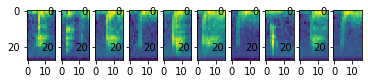

In [376]:
# get some random training spectrograms
train_dataiter = iter(train_loader)
spectrograms, labels = train_dataiter.next()
batch_size = train_params['batch_size']

# show spectrograms
fig, ax = plt.subplots(1, batch_size)
for i in range(len(spectrograms)):
    if batch_size == 1:
        ax.imshow(spectrograms[i][0].numpy()) # the 0 selects the first (only) channel
    else:
        ax[i].imshow(spectrograms[i][0].numpy()) # the 0 selects the first (only) channel

# print labels
print(' '.join('%4s' % noise_int_to_str[labels[j].item()] for j in range(batch_size)))

Let's also check what balance we achieved in the training set, just to make sure there's a reasonably even number of different types of noise.

In [377]:
def count_noise_types_in_dataset(dataset):
    counts = {}
    for s, n_int in dataset:
        try:
            counts[n_int] += 1
        except:
            counts[n_int] = 1
    return { noise_int_to_str[k]: v for k, v in counts.items() }

print(count_noise_types_in_dataset(train_dataset))
print(count_noise_types_in_dataset(test_dataset))

{'p': 112, 't': 118}
{'p': 30, 't': 28}


Very good, it seems the random split came out pretty even.

Before we move on to the CNN, let's check the resolution of each spectrogram, and confirm it's the same for all.

In [378]:
image_size = full_dataset[0][0].size() # first image of first batch
for s, l in full_dataset:
    if s.size() != image_size:
        print("Image size does not match.")

print(image_size)

torch.Size([1, 28, 16])


# Preparing the CNN

Much of this section is adapted from https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py.

Let's begin by trying two convolution layers, and three dense layers.

In [379]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, image_size):
        super(Net, self).__init__()
        
        # image_size is a 2-tuple, the expected dimensions of each spectrogram
        channels, h, w = image_size
        
        # number of output nodes, (square) kernel size, and pool size per convolution layer,
        # assuming the stride for pooling is the same as the pool size
        kernels = [3, 3]
        pool = 2
        
        # compute the number of input nodes for the first dense layer
        h_out, w_out = h, w
        for k in kernels:
            # the convolution.
            h_out += -k + 1
            w_out += -k + 1
            
            # the pool. (from help(torch.nn.MaxPool2d))
            h_out = int( (h_out - pool) / pool + 1 )
            w_out = int( (w_out - pool) / pool + 1 )
            
        self.image_out = h_out * w_out
        
        # number of output nodes for final dense layer: the number of noise types
        N_noises = len(noise_int_to_str) # the total number of noise types
        
        # define the layers. The numbers of nodes chosen do not have deep thought behind them.
        self.conv0 = nn.Conv2d(1, 32, kernels[0])
        self.pool = nn.MaxPool2d(2)
        self.conv1 = nn.Conv2d(32, 10, kernels[1])
        self.fc0 = nn.Linear(10 * self.image_out, 50)
        self.fc1 = nn.Linear(50, 10)
        self.fc2 = nn.Linear(10, N_noises)

    def forward(self, x):
        x = self.pool(F.relu(self.conv0(x)))
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, 10 * self.image_out)
        x = F.relu(self.fc0(x))
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    
net = Net(image_size)

There are far more parameters than data.

In [380]:
print("There are %d parameters." % (
    sum([ p.numel() for p in net.parameters() ])))
print("There are %d data samples." % (len(full_dataset)))

There are 8792 parameters.
There are 288 data samples.


Does the net accept our data, as we hope?

In [381]:
for data in train_loader:
    inputs, labels = data
    print(net(inputs))
    break

tensor([[ 0.2557, -0.2268],
        [ 0.2411, -0.2099],
        [ 0.2725, -0.1923],
        [ 0.1479, -0.2086],
        [ 0.1295, -0.2174],
        [ 0.1875, -0.1994],
        [ 0.2658, -0.2029],
        [ 0.2365, -0.1832],
        [ 0.2495, -0.2002],
        [ 0.1454, -0.2185]], grad_fn=<AddmmBackward>)


Next we need to define a cost function, and an optimizer to determine how our net should learn.

For cost, we'll choose CrossEntropyLoss, which particularly penalizes high confidence in wrong answers. 

For an optimizer, we'll go with the common Stochasic Gradient Descent, without momentum for now.

In [382]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

In [383]:
def train_net(net, epochs, epoch_progress=10, batch_progress=50):
    epoch_running_loss = 0.0
    batch_num = 0
    for epoch in range(epochs):  # loop over the dataset multiple times
        
        batch_running_loss = 0.0
        
        for i, data in enumerate(train_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # accrue loss for printing
            batch_running_loss += loss.item()
            epoch_running_loss += loss.item()
            batch_num += 1
            
            if i % batch_progress == batch_progress-1:
                print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, batch_running_loss / batch_progress))
                batch_running_loss = 0.0
        
        if epoch % epoch_progress == epoch_progress-1:
            print('[%d] loss: %.3f' %
                  (epoch + 1, epoch_running_loss / batch_num))
            running_loss = 0.0
            batch_num = 0
        
    print('Finished Training')

In [384]:
train_net(net, 100)

[10] loss: 0.119
[20] loss: 0.140
[30] loss: 0.144
[40] loss: 0.146
[50] loss: 0.147
[60] loss: 0.147
[70] loss: 0.147
[80] loss: 0.147
[90] loss: 0.147
[100] loss: 0.147
Finished Training


How does this perform on the testing data?

In [385]:
def accuracy_rating(dataloader, label):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in dataloader:
            spectrograms, labels = data
            outputs = net(spectrograms)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the %d %s spectrograms: %d %%' % (
        total,
        label,
        100 * correct / total))

accuracy_rating(train_loader, 'training')
accuracy_rating(test_loader, 'test')

Accuracy of the network on the 230 training spectrograms: 100 %
Accuracy of the network on the 58 test spectrograms: 98 %


Very nice. It doesn't even seem to have overfit, and we didn't even need to augment the data.